In [1]:
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn import tree
import pickle
import random
import numpy as np
import seaborn as sns

In [ ]:
TRAINING = False # Set False for testing

In [2]:
data = pd.read_csv('../CSVs/UTKFace_sample.csv')
image_filenames = data['filename']
labels_age = data['age']

In [3]:
features = []
labels_age_encoded = []

In [4]:
def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    flattened_features = gray.flatten()  
    
    return flattened_features

In [5]:
for image_filename in image_filenames:
    image_path = os.path.join('../UTKFace/', image_filename)
    image = cv2.imread(image_path)
    img_features = extract_features(image)
    features.append(img_features)

In [6]:
# Age labels
labels_age_encoded = pd.cut(labels_age, bins=[0, 28, 116], labels=[0, 1], include_lowest=True).astype(int)

In [7]:
X_train, X_test, y_train_age, y_test_age = train_test_split(
    features, labels_age_encoded, test_size=0.8, random_state=42
)

In [8]:
def semi_supervised_dtc(labeled_X, labeled_y, unlabeled_X, confidence_threshold):
    # Initialize Decision Tree classifier
    clf = DecisionTreeClassifier(criterion="gini", max_depth=7)

    # Number of iterations
    num_iterations = 5

    # Iterative semi-supervised training
    for i in range(num_iterations):
        # Train the Decision Tree classifier using labeled data
        print("\nNumber of samples for iteration", (i+1), "=", len(labeled_X))
        clf.fit(labeled_X, labeled_y)
        
        # Predict labels for unlabeled data
        predicted_labels = clf.predict(unlabeled_X)

        # Evaluate performance on labeled data
        labeled_predictions = clf.predict(labeled_X)
        accuracy = accuracy_score(labeled_y, labeled_predictions)
        
        new_unlabeled_X = []

        # Update labeled data with confident predicted labels
        for j, label in enumerate(predicted_labels):
            if (clf.predict_proba(unlabeled_X[j].reshape(1, -1))[0].max()) >= confidence_threshold:
                labeled_X = np.append(labeled_X, [unlabeled_X[j]], axis=0)
                labeled_y = np.append(labeled_y, [label])
            else:
                new_unlabeled_X.append(unlabeled_X[j])
        
        unlabeled_X = np.array(new_unlabeled_X)
        
        print(f"Iteration {i+1}: Accuracy = {accuracy}")

    return clf

In [9]:
print("For Age:")
if TRAINING:
    age_classifier = semi_supervised_dtc(X_train, y_train_age, X_test, 0.7)
else:
    age_classifier = pickle.load(open("models/age_semisupervised.pkl", "rb"))

For Age:

Number of samples for iteration 1 = 4741
Iteration 1: Accuracy = 0.8175490402868593

Number of samples for iteration 2 = 19990
Iteration 2: Accuracy = 0.9137568784392196

Number of samples for iteration 3 = 22620
Iteration 3: Accuracy = 0.9173297966401415

Number of samples for iteration 4 = 23034
Iteration 4: Accuracy = 0.9058348528262569

Number of samples for iteration 5 = 23067
Iteration 5: Accuracy = 0.905969566913773


In [ ]:
# Uncomment below code to save model

# age_pickle = open("models/age_semisupervised.pkl", "wb")
# pickle.dump(age_classifier,age_pickle)
# age_pickle.close()

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.4)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

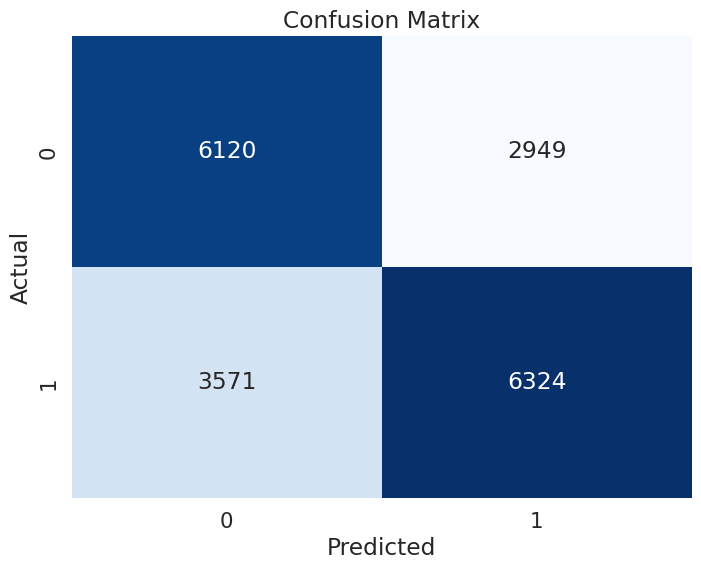

In [11]:
predictions_age = age_classifier.predict(X_test)
plot_confusion_matrix(y_test_age, predictions_age)

In [12]:
accuracy_age = accuracy_score(y_test_age, predictions_age)
print(f"Age Accuracy: {accuracy_age}")

Age Accuracy: 0.6561906770723476


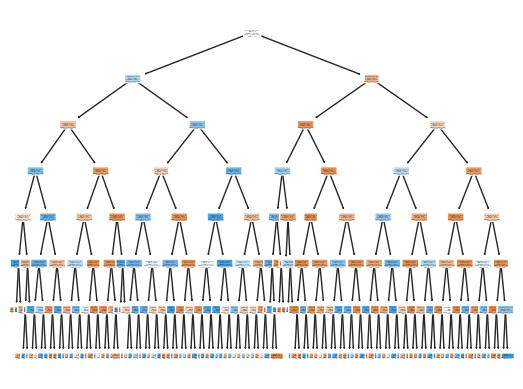

In [14]:
tree.plot_tree(age_classifier, filled=True, proportion=True, rounded=True, class_names=["<=28",">28"]) 
plt.savefig("tree.png", dpi=750)